In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score

SEED   = 3333
EPOCHS = 500
gpu = torch.cuda.is_available()

In [2]:
df = pd.read_csv("AAPL.csv")
df = df[["Date","Close"]]

df.index = pd.to_datetime(df['Date'])
dates = pd.date_range(df.index.min(), df.index.max())
df = df.reindex(dates, fill_value=0)
df = df.drop('Date', axis=1)
df.replace(0, np.NaN, inplace=True)
df = df.interpolate()
df

,Close
1981-01-02,0.154018
1981-01-03,0.152902
1981-01-04,0.151786
1981-01-05,0.150670
1981-01-06,0.143973
...,...
2020-12-27,135.510002
2020-12-28,136.690002
2020-12-29,134.869995
2020-12-30,133.720001


In [3]:
window = 7

X = []
y = []

for i in range(window, len(df)):

    if window+i < len(df):
        X.append(df['Close'].iloc[i-window:i].values.tolist())
        y.append(df['Close'].iloc[i:window+i].values.tolist())
    else:
        break

_X = np.array(X)
_y = np.asarray(y)

print(_X.shape, _y.shape)

(14595, 7) (14595, 7)


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size=0.2, random_state=SEED)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=SEED)

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

(11676, 7) (11676, 7) (1460, 7) (1460, 7) (1459, 7) (1459, 7)


In [5]:
class ResLayer(torch.nn.Module):
    
    def __init__(self, in_units, width):
        
        super(ResLayer, self).__init__()
        self.linear  = torch.nn.Linear(width, width)
        self.layer_norm     = torch.nn.LayerNorm(in_units)
    
    def forward(self, x):
        
        out = self.layer_norm(x)
        out = torch.nn.functional.relu(out)
        out = self.linear(out)
                          
        return x + out
        
def make_network(input_dim=7, width=64, L=2, out_features=7):
    
    network = torch.nn.Sequential(torch.nn.Linear(input_dim, width), 
                                  * [ResLayer(width, width) for _ in range(L)],
                                  torch.nn.LayerNorm(width), 
                                  torch.nn.Linear(width, out_features))
    return network


In [6]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)

X_valid = torch.Tensor(X_valid)
y_valid = torch.Tensor(y_valid)

X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

In [7]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train) 
valid_dataset = torch.utils.data.TensorDataset(X_valid, y_valid) 
test_dataset = torch.utils.data.TensorDataset(X_test, y_test) 

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, drop_last=True, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=512, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=512, drop_last=True)

In [8]:
net = make_network()

if gpu:
    net.cuda()

loss_function = torch.nn.L1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

In [9]:
for epoch in range(1, EPOCHS+1):
    
    net.train(True)
    running_loss = 0.0
    
    # Iterate over batches
    for index, batch in enumerate(train_dataloader):

        inputs, targets = batch
        if gpu:
            inputs = inputs.cuda()
            targets = targets.cuda()

        # Zero the gradients for every batch
        optimizer.zero_grad()

        # Perform forward pass
        outputs = net(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()
        
        running_loss += loss.item()
    
    if epoch % 10 == 0:
        
        net.train(False)
        running_vloss = 0.0
        
        for _index, _batch in enumerate(valid_dataloader):
            
            _inputs, _targets = _batch
            if gpu:
                _inputs = _inputs.cuda()
                _targets = _targets.cuda()
                
            _outputs = net(_inputs)
            _loss = loss_function(_outputs, _targets)
            running_vloss += _loss.item()
        
        avg_loss  = running_loss / (index + 1)
        avg_vloss = running_vloss / (_index + 1)
        print(f"Epoch {epoch} \t Training Loss: {avg_loss:.5f} \t Validation Loss: {avg_vloss:.5f}")

Epoch 10 	 Training Loss: 7.66051 	 Validation Loss: 7.21072
Epoch 20 	 Training Loss: 5.71472 	 Validation Loss: 5.38827
Epoch 30 	 Training Loss: 4.14970 	 Validation Loss: 3.95286
Epoch 40 	 Training Loss: 3.09125 	 Validation Loss: 2.94806
Epoch 50 	 Training Loss: 2.42452 	 Validation Loss: 2.30585
Epoch 60 	 Training Loss: 1.92219 	 Validation Loss: 1.81714
Epoch 70 	 Training Loss: 1.60155 	 Validation Loss: 1.48774
Epoch 80 	 Training Loss: 1.39036 	 Validation Loss: 1.26880
Epoch 90 	 Training Loss: 1.23452 	 Validation Loss: 1.10836
Epoch 100 	 Training Loss: 1.11651 	 Validation Loss: 0.98480
Epoch 110 	 Training Loss: 1.00772 	 Validation Loss: 0.87653
Epoch 120 	 Training Loss: 0.90721 	 Validation Loss: 0.78295
Epoch 130 	 Training Loss: 0.82570 	 Validation Loss: 0.71019
Epoch 140 	 Training Loss: 0.75919 	 Validation Loss: 0.63851
Epoch 150 	 Training Loss: 0.70177 	 Validation Loss: 0.55486
Epoch 160 	 Training Loss: 0.63931 	 Validation Loss: 0.50647
Epoch 170 	 Train

In [10]:
net.train(False)
correct, total = 0, 0

for index, batch in enumerate(test_dataloader):

    _inputs, _targets = _batch
    if gpu:
        _inputs = _inputs.cuda()
        _targets = _targets.cuda()

    _outputs = net(_inputs)

In [11]:
from sklearn.metrics import r2_score

y_pred = _outputs.cpu().detach().numpy()
y_true = _targets.cpu().detach().numpy()

r2_score(y_true, y_pred)

0.9983975301941247

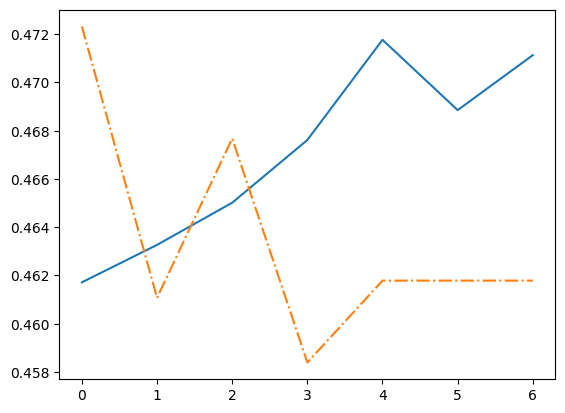

In [12]:
import matplotlib.pyplot as plt

plt.plot(y_pred[511])
plt.plot(y_true[511], '-.')
plt.show()